In [4]:
!nvidia-smi

Mon Apr 17 07:21:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# ResNet

到最后了还是忍不住想用ResNet试一下，因为ResNet给人的美感太强了，虽然自己已经交作业了，不过还是很想看看ResNet的效果。这个notebook估计自己想这样做，先自己从头训练一下看看效果，再用预训练的模型试一下。

## 从头开始的ResNet

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

### 定义残差块

这里借鉴了李沐老师的动手学习深度学习的代码，架构如下：

![resnet](resnet-block.svg)


In [ ]:
class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

#### 残差块小测试

我们测试一下输入输出的维度是怎么样的：

In [ ]:
X = torch.rand((4, 3, 6, 6))
resBlock = Residual(3, 3)
resBlock(X).shape # torch.Size([4, 3, 6, 6]) # same shape

torch.Size([4, 3, 6, 6])

In [ ]:
resBlock = Residual(3, 6, use_1x1conv=True, strides=2)
resBlock(X).shape # torch.Size([4, 6, 3, 3]) # 1/2 shape

torch.Size([4, 6, 3, 3])

复习一下`nn.Conv2d`的输入输出大小计算公式

$$
\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
        \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
$$

$$
H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                        \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor 
$$

$$
W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
                        \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor
$$

In [ ]:
nn.Conv2d(3, 3, kernel_size=3, padding=1, stride=1)(X).shape # torch.Size([4, 3, 6, 6]) # same shape

torch.Size([4, 3, 6, 6])

In [ ]:
nn.Conv2d(3, 3, kernel_size=3, padding=1, stride=2)(X).shape # torch.Size([4, 3, 3, 3]) # 1/2 shape

torch.Size([4, 3, 3, 3])

### 定义ResNet的block

ResNet在第一个block的时候是和谷歌的Inception是一样的，不同的是ResNet在卷积层之后加了一个BatchNorm层。

In [ ]:
block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                          nn.BatchNorm2d(64), nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
X = torch.rand((4, 3, 224, 224))
block1(X).shape # torch.Size([4, 64, 56, 56])

torch.Size([4, 64, 56, 56])

In [ ]:
# 定义除了block1之外的block网络结构
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [ ]:
# 接着在ResNet加入所有残差块，这里每个模块使用2个残差块。这样我们下面每个模块就有4个卷积层，下面就一共16个卷积层
block2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
block3 = nn.Sequential(*resnet_block(64, 128, 2))
block4 = nn.Sequential(*resnet_block(128, 256, 2))
block5 = nn.Sequential(*resnet_block(256, 512, 2))

#### 残差block小测试

In [ ]:
X = torch.rand((4, 64, 56, 56))
block2(X).shape # torch.Size([4, 64, 56, 56])

torch.Size([4, 64, 56, 56])

In [ ]:
block3(X).shape # torch.Size([4, 128, 28, 28])

torch.Size([4, 128, 28, 28])

In [ ]:
X = torch.rand((4, 128, 28, 28))
block4(X).shape # torch.Size([4, 256, 14, 14])

torch.Size([4, 256, 14, 14])

In [ ]:
X = torch.rand((4, 256, 14, 14))
block5(X).shape # torch.Size([4, 512, 7, 7])

torch.Size([4, 512, 7, 7])

In [ ]:
X = torch.rand((4, 512, 7, 7))
nn.AdaptiveAvgPool2d((1, 1))(X).shape # torch.Size([4, 512, 1, 1])

torch.Size([4, 512, 1, 1])

### 定义ResNet18

In [ ]:
ResNet18 = nn.Sequential(block1, block2, block3, block4, block5,
                          nn.AdaptiveAvgPool2d((1, 1)),
                            nn.Flatten(),
                            nn.Linear(512, 10))

In [ ]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in ResNet18:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
from torchinfo import summary
summary(ResNet18, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,472
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─Residual: 2-5                     [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    └─Residual: 2-6                     [1, 64, 56, 56]           --
│

## 训练过程

In [ ]:
learning_rate = 0.001
batch_size = 128
num_epochs = 5

### 加载数据集及可视化

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

# 定义 transform，包括缩放、中心裁剪、随机水平翻转、归一化
transform_train = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

# 只需要归一化和中心裁剪
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 加载 CIFAR10 数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


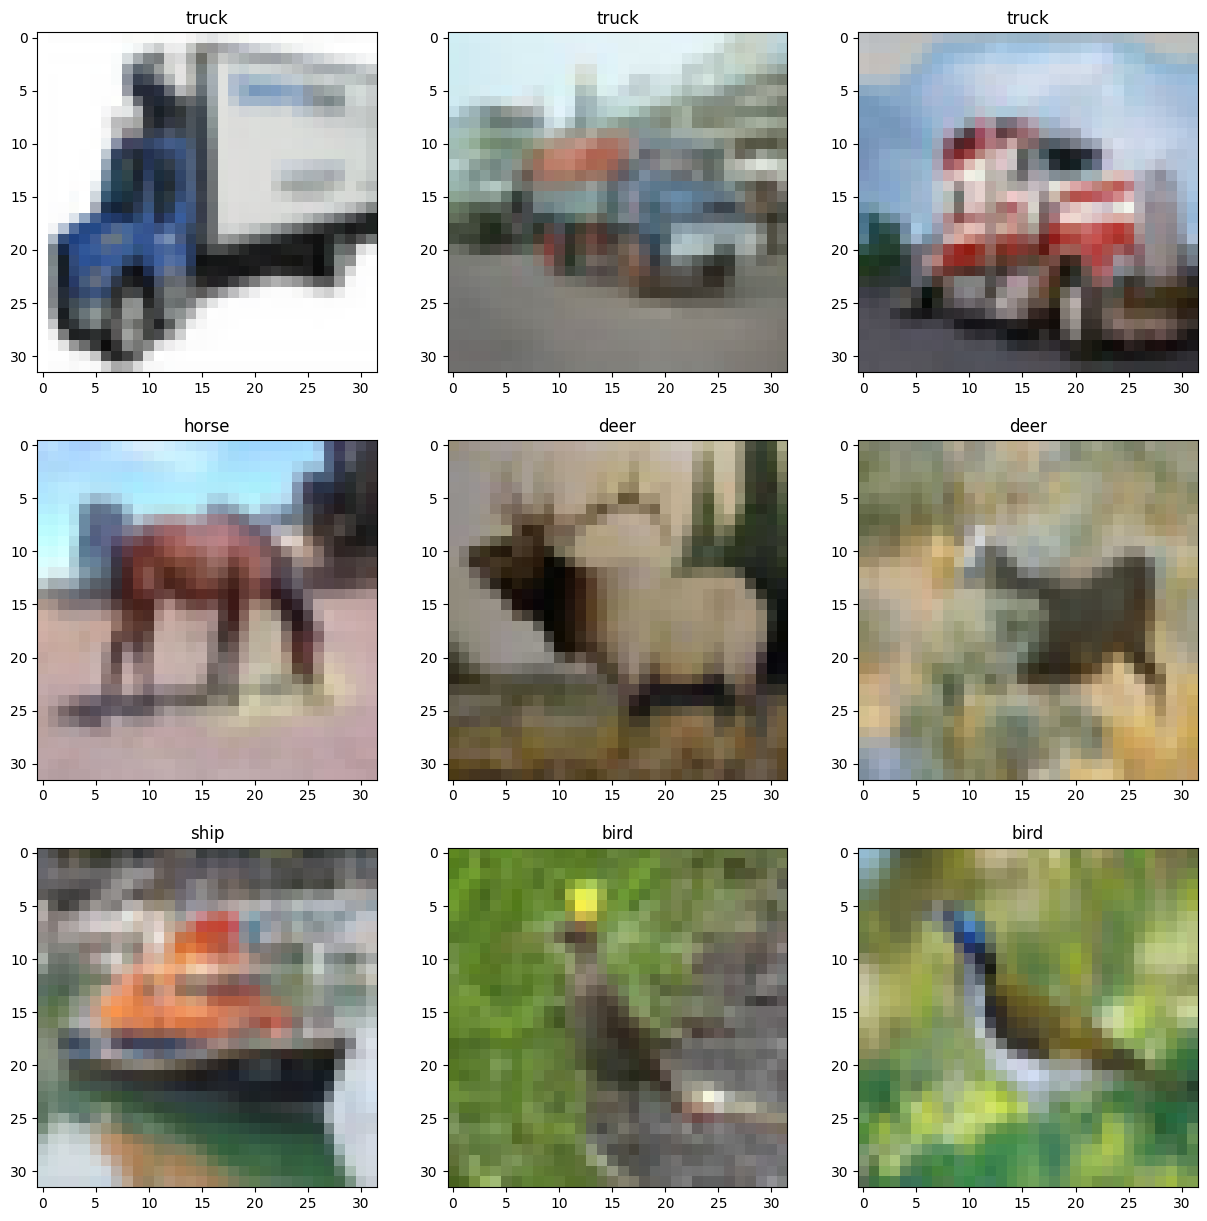

In [7]:
def display(dataset = trainset):
    # 展示一下数据集
    import matplotlib.pyplot as plt
    import numpy as np

    indexs = np.random.randint(0, len(dataset), 9)

    imgs = [dataset.data[i] for i in indexs]
    labels = [dataset.targets[i] for i in indexs]
    classes = dataset.classes

    fig = plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = fig.add_subplot(3, 3, i+1)
        ax.imshow(imgs[i])
        ax.set_title(classes[labels[i]])

display()

### 定义训练函数

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 下面训练和验证的代码部分参考了微软家的pytorch教程
# https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/6-transfer-learning
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        lbls = labels.to(device)
        out = net(features.to(device))
        loss = loss_fn(out,lbls) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==lbls).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(device)
            out = net(features.to(device))
            loss += loss_fn(out,lbls) 
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [9]:
def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(device)
            optimizer.zero_grad()
            out = net(features.to(device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(net,test_loader,loss_fn)
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))

In [ ]:
loss_fn = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(ResNet18.parameters(), lr=0.01) # 使用 Adam 优化器
epochs = 10
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
train_long(ResNet18,trainloader,testloader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=epochs,print_freq=50)

Epoch 0, minibatch 0: train acc = 0.1015625, train loss = 0.00915361475199461
Epoch 0, minibatch 50: train acc = 0.14736519607843138, train loss = 0.009552977833093381
Epoch 0, minibatch 100: train acc = 0.1975943688118812, train loss = 0.00863521405965975
Epoch 0, minibatch 150: train acc = 0.23828125, train loss = 0.008086427947543315
Epoch 0 done, validation acc = 0.3742, validation loss = 0.006700816345214844
Epoch 1, minibatch 0: train acc = 0.37109375, train loss = 0.006364266853779554
Epoch 1, minibatch 50: train acc = 0.4114583333333333, train loss = 0.006121984883850696
Epoch 1, minibatch 100: train acc = 0.4303449876237624, train loss = 0.005993126642585981
Epoch 1, minibatch 150: train acc = 0.44603683774834435, train loss = 0.0058372593083918485
Epoch 1 done, validation acc = 0.431, validation loss = 0.006391253280639648
Epoch 2, minibatch 0: train acc = 0.515625, train loss = 0.005131948739290237
Epoch 2, minibatch 50: train acc = 0.5314031862745098, train loss = 0.0049636

In [ ]:
train_long(ResNet18,trainloader,testloader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=epochs,print_freq=50)

Epoch 0, minibatch 0: train acc = 0.890625, train loss = 0.0010258532129228115
Epoch 0, minibatch 50: train acc = 0.8748468137254902, train loss = 0.0013938610460243973
Epoch 0, minibatch 100: train acc = 0.8794477103960396, train loss = 0.0013546806455838798
Epoch 0, minibatch 150: train acc = 0.8786216887417219, train loss = 0.0013682154432827275
Epoch 0 done, validation acc = 0.808, validation loss = 0.002359017562866211
Epoch 1, minibatch 0: train acc = 0.92578125, train loss = 0.000928666559047997
Epoch 1, minibatch 50: train acc = 0.9063265931372549, train loss = 0.001065797519450094
Epoch 1, minibatch 100: train acc = 0.904006806930693, train loss = 0.0010919823209838112
Epoch 1, minibatch 150: train acc = 0.9022144039735099, train loss = 0.001102832867609744
Epoch 1 done, validation acc = 0.807, validation loss = 0.002357396697998047
Epoch 2, minibatch 0: train acc = 0.90625, train loss = 0.0009684089454822242
Epoch 2, minibatch 50: train acc = 0.9191176470588235, train loss = 

## 总结规划下一步

> 可以看到一共跑了20轮的结果也不是很好，0.818的准确率，在这个程度上还比不上用VGG迁移模型的结果。19+28=47min

下面我们计划用一下ResNet的预训练模型来重新试一下。

In [23]:
import torchvision.models as models
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet101 = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 240MB/s]


In [24]:
from torchinfo import summary
summary(resnet18, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

### resnet18

试图改一下resnet中最后的分类器。

In [25]:
resnet18 = resnet18.to(device)

In [26]:
resnet18.fc = nn.Linear(512,10).to(device)

In [27]:
for x in resnet18.parameters():
    x.requires_grad = False

for x in resnet18.fc.parameters():
    x.requires_grad = True

In [30]:
summary(resnet18, input_size=(128, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 112, 112]       (9,408)
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       (128)
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-6                    [128, 64, 56, 56] 

In [31]:
loss_fn = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001) # 使用 Adam 优化器
epochs = 3
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
train_long(resnet18,trainloader,testloader,epochs=epochs,optimizer = optimizer,loss_fn=torch.nn.CrossEntropyLoss(),print_freq=50)

Epoch 0, minibatch 0: train acc = 0.1328125, train loss = 0.01911235600709915
Epoch 0, minibatch 50: train acc = 0.44332107843137253, train loss = 0.013426314381992115
Epoch 0, minibatch 100: train acc = 0.5496596534653465, train loss = 0.011156915438057172
Epoch 0, minibatch 150: train acc = 0.5987686258278145, train loss = 0.009954570934472495
Epoch 0, minibatch 200: train acc = 0.6278762437810945, train loss = 0.009208872543638618
Epoch 0, minibatch 250: train acc = 0.6491222609561753, train loss = 0.008655056060547847
Epoch 0, minibatch 300: train acc = 0.6635953073089701, train loss = 0.00825174464735874
Epoch 0, minibatch 350: train acc = 0.6758814102564102, train loss = 0.00794188928739977
Epoch 0 done, validation acc = 0.7521, validation loss = 0.005845168304443359
Epoch 1, minibatch 0: train acc = 0.71875, train loss = 0.006415348965674639
Epoch 1, minibatch 50: train acc = 0.7519914215686274, train loss = 0.0057582586419348625
Epoch 1, minibatch 100: train acc = 0.74930383663

In [32]:
optimizer.param_groups[0]['lr']

0.001

In [33]:
optimizer.param_groups[0]['lr'] = 1e-5

In [34]:
train_long(resnet18,trainloader,testloader,epochs=2,optimizer = optimizer,loss_fn=torch.nn.CrossEntropyLoss(),print_freq=50)

Epoch 0, minibatch 0: train acc = 0.734375, train loss = 0.005999831948429346
Epoch 0, minibatch 50: train acc = 0.7775735294117647, train loss = 0.00509604577924691
Epoch 0, minibatch 100: train acc = 0.7850402227722773, train loss = 0.004953683602927935
Epoch 0, minibatch 150: train acc = 0.7843543046357616, train loss = 0.004964422311214422
Epoch 0, minibatch 200: train acc = 0.7826103855721394, train loss = 0.004985396541766266
Epoch 0, minibatch 250: train acc = 0.7825883964143426, train loss = 0.004975365927494854
Epoch 0, minibatch 300: train acc = 0.7821324750830565, train loss = 0.004972671353539755
Epoch 0, minibatch 350: train acc = 0.7818732193732194, train loss = 0.004977933701626596
Epoch 0 done, validation acc = 0.7805, validation loss = 0.005105568695068359
Epoch 1, minibatch 0: train acc = 0.7734375, train loss = 0.004417629446834326
Epoch 1, minibatch 50: train acc = 0.7771139705882353, train loss = 0.0049811771102980075
Epoch 1, minibatch 100: train acc = 0.779238861

In [ ]:
## 尝试开始微调
for x in resnet18.parameters():
    x.requires_grad = True

loss_fn = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001) # 使用 Adam 优化器
epochs = 2
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
train_long(resnet18,trainloader,testloader,epochs=epochs,optimizer = optimizer,loss_fn=torch.nn.CrossEntropyLoss(),print_freq=50)


> 可以看到靠预训练模型前期训练测试集准确率提升确实很快，但是在后期却不如之前自己定义的从头开始训练的数据，就是以为提取特征从层没有很好的去fit我们的CIFAR10数据集

### resnet50



In [36]:
resnet50 = resnet50.to(device)

In [37]:
resnet50.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [38]:
resnet50.fc = nn.Linear(2048,10).to(device)

In [39]:
for x in resnet50.parameters():
    x.requires_grad = False

for x in resnet50.fc.parameters():
    x.requires_grad = True

In [40]:
summary(resnet50, input_size=(128, 3, 224, 224))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 112, 112]       (9,408)
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       (128)
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 256, 56, 56]        --
│    └─Bottleneck: 2-1                   [128, 256, 56, 56]        --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         (4,096)
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-6                    [128, 64, 56, 56]  

In [41]:
loss_fn = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001) # 使用 Adam 优化器
epochs = 3
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
train_long(resnet50,trainloader,testloader,epochs=epochs,optimizer = optimizer,loss_fn=torch.nn.CrossEntropyLoss(),print_freq=50)

Epoch 0, minibatch 0: train acc = 0.0859375, train loss = 0.018274305388331413
Epoch 0, minibatch 50: train acc = 0.5246629901960784, train loss = 0.012859863393446979
Epoch 0, minibatch 100: train acc = 0.5928991336633663, train loss = 0.010874475582991497
Epoch 0, minibatch 150: train acc = 0.6276903973509934, train loss = 0.009791635519621388
Epoch 0, minibatch 200: train acc = 0.6489816542288557, train loss = 0.009124735694619553
Epoch 0, minibatch 250: train acc = 0.664093625498008, train loss = 0.008640561920713144
Epoch 0, minibatch 300: train acc = 0.6750674833887044, train loss = 0.008282415098526154
Epoch 0, minibatch 350: train acc = 0.6840500356125356, train loss = 0.00799721326583471
Epoch 0 done, validation acc = 0.7416, validation loss = 0.006082545852661133
Epoch 1, minibatch 0: train acc = 0.7734375, train loss = 0.005886969622224569
Epoch 1, minibatch 50: train acc = 0.7544424019607843, train loss = 0.005847047356998219
Epoch 1, minibatch 100: train acc = 0.7529393564

In [42]:
## 尝试开始微调
for x in resnet50.parameters():
    x.requires_grad = True


In [43]:

loss_fn = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001) # 使用 Adam 优化器
epochs = 1
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
train_long(resnet50,trainloader,testloader,epochs=epochs,optimizer = optimizer,loss_fn=torch.nn.CrossEntropyLoss(),print_freq=50)


Epoch 0, minibatch 0: train acc = 0.7109375, train loss = 0.005541874095797539
Epoch 0, minibatch 50: train acc = 0.7948835784313726, train loss = 0.004714654649005216
Epoch 0, minibatch 100: train acc = 0.8270420792079208, train loss = 0.003959574026636558
Epoch 0, minibatch 150: train acc = 0.8397144039735099, train loss = 0.0036680801025289573
Epoch 0, minibatch 200: train acc = 0.8485307835820896, train loss = 0.0034899643404566827
Epoch 0, minibatch 250: train acc = 0.8565425796812749, train loss = 0.0033150878085558156
Epoch 0, minibatch 300: train acc = 0.8616330980066446, train loss = 0.003207599997916491
Epoch 0, minibatch 350: train acc = 0.8665420227920227, train loss = 0.0030967662816713338
Epoch 0 done, validation acc = 0.8838, validation loss = 0.002771183204650879


In [44]:
train_long(resnet50,trainloader,testloader,epochs=10,optimizer = optimizer,loss_fn=torch.nn.CrossEntropyLoss(),print_freq=50)


Epoch 0, minibatch 0: train acc = 0.9453125, train loss = 0.0011647266801446676
Epoch 0, minibatch 50: train acc = 0.9234068627450981, train loss = 0.001740895942145703
Epoch 0, minibatch 100: train acc = 0.921565594059406, train loss = 0.001744380534285366
Epoch 0, minibatch 150: train acc = 0.9210989238410596, train loss = 0.0017407810845911898
Epoch 0, minibatch 200: train acc = 0.9219527363184079, train loss = 0.0017409203064382374
Epoch 0, minibatch 250: train acc = 0.921906125498008, train loss = 0.0017588054278932245
Epoch 0, minibatch 300: train acc = 0.9223421926910299, train loss = 0.0017499711822433724
Epoch 0, minibatch 350: train acc = 0.9221198361823362, train loss = 0.0017640470099924636
Epoch 0 done, validation acc = 0.8777, validation loss = 0.0028677675247192383
Epoch 1, minibatch 0: train acc = 0.9453125, train loss = 0.0015196764143183827
Epoch 1, minibatch 50: train acc = 0.9483762254901961, train loss = 0.0012008991895937453
Epoch 1, minibatch 100: train acc = 0.9

KeyboardInterrupt: ignored

> 使用ResNet50达到90%以上了,很不错的模型了。